### Fourier Transform 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from numpy import fft 
import random
import os 


## Search method practice

[ 1.-1.j  1.-1.j  1.+1.j -1.-1.j  1.-1.j -1.-1.j  1.+1.j  1.+1.j  1.-1.j
  1.+1.j]
0 (0.9368460019418294-0.11951087541719306j)
1 (0.013345024361539828-0.3121002357768112j)
2 (0.5869895691023036+0.7879403489349359j)
3 (-1.8147502042756463-0.38113890195133177j)
4 (0.5895352673049186-1.0984609049270282j)
5 (-0.674585159050482-2.0481612953816115j)
6 (0.14841184854296652+0.9489354080973402j)
7 (0.155062688301182+1.0254264600150798j)
8 (0.8837815877236224-0.13964276382221577j)
9 (1.7299413426183858+0.13171533033885388j)


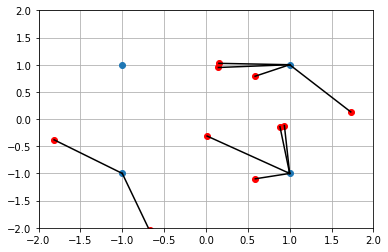

In [3]:
x_r = np.random.randn(10)
x_i = np.random.randn(10) 
x = x_r + 1j * x_i 
cp_r = []

cpoints = np.array([
    -1-1j,
    -1+1j, 
    1+1j,
    1-1j,
])
plt.plot(cpoints.real, cpoints.imag, 'o')
plt.plot(x_r, x_i, 'or')

compare = np.abs(x - cpoints.reshape(-1, 1))
dets = np.array([cpoints[i] for i in np.argmin(compare, axis=0)])
print(dets)

for i, cp in enumerate(x):
    print(i, cp) 
    plt.plot([dets[i].real, cp.real], [dets[i].imag, cp.imag], 'k-')

plt.grid() 
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.show()


In [12]:
c = 2
x_estimated = x
x_detected = dets 
x_exact = cpoints.reshape(-1, 1)
x_estimated, x_detected, x_exact 

(array([ 1.46707364-0.17529495j,  0.67826399+0.66004183j,
        -1.15626819+0.1984927j , -0.76018229-0.85921641j,
        -0.89683452+1.04548489j, -0.5997528 +0.23669945j,
         2.40502155+0.85174651j, -0.79211292+0.7745666j ,
         1.30878128-0.41610247j, -2.00853931+0.21626987j]),
 array([ 1.-1.j,  1.+1.j, -1.+1.j, -1.-1.j, -1.+1.j, -1.+1.j,  1.+1.j,
        -1.+1.j,  1.-1.j, -1.+1.j]),
 array([[-1.-1.j],
        [-1.+1.j],
        [ 1.+1.j],
        [ 1.-1.j]]))

In [13]:
nominator = np.abs(x_estimated - x_exact)
denominator = np.abs(x_estimated - x_detected)

In [14]:
print(nominator)
print(denominator)
condition = nominator / denominator < c

[[2.60126715 2.36057385 1.20863746 0.27808731 2.04808485 1.29985513
  3.87596915 1.78670189 2.38147167 1.58002023]
 [2.73272219 1.71234972 0.81659886 1.87461948 0.11274746 0.86187327
  3.40824747 0.30665495 2.70847138 1.27725661]
 [1.26470392 0.46806583 2.30041441 2.56025924 1.8973798  1.77252271
  1.41282152 1.80623612 1.44937644 3.10894543]
 [0.94778489 1.69093257 2.46695709 1.76580342 2.78962177 2.02203723
  2.32444632 2.52205379 0.66051662 3.24509186]]
[0.94778489 0.46806583 0.81659886 0.27808731 0.11274746 0.86187327
 1.41282152 0.30665495 0.66051662 1.27725661]


In [15]:
# search nML 

print(np.sum(condition.T, axis=1))
nnset = np.array(np.nonzero(condition.T))
# np.array([cpoints[i] for i in np.nonzero(condition.T)[1]])

nn = [[] for _ in range(10)]
for k, m in nnset.T:

    nn[k].append(m) 
print(nn)
new = []
for n in nn:
    new.append(list(np.take(cpoints, n)))
new

[2 1 2 1 1 2 2 1 1 2]
[[2, 3], [2], [0, 1], [0], [1], [0, 1], [2, 3], [1], [3], [0, 1]]


[[(1+1j), (1-1j)],
 [(1+1j)],
 [(-1-1j), (-1+1j)],
 [(-1-1j)],
 [(-1+1j)],
 [(-1-1j), (-1+1j)],
 [(1+1j), (1-1j)],
 [(-1+1j)],
 [(1-1j)],
 [(-1-1j), (-1+1j)]]

## MIMO Receiver with 1-bit-ADC (Linear Receiver) for 1 timestep

In [3]:
K = 4
N = 8
M = 4 

def make_symbol_space(K, M, cp):
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.vstack((x.real, x.imag))
    z_re = np.vstack((z.real, x.imag))
    r_re = np.vstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

# symbols for 1-timeslot 
x = np.random.randint(0, M, size=K).reshape(-1, 1) 
x = np.take(constellation_points, x)

# Channel 
H = (1 / np.sqrt(2)) * (np.random.randn(N, K) + 1j * np.random.randn(N, K))
z = (1 / np.sqrt(2)) * (np.random.randn(N, 1) + 1j * np.random.randn(N, 1))

r = np.matmul(H, x) + z 

# Complex to real representation 
H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

# 1-bit ADC 
y = np.sign(r_re) 

# relaxed linear receiver 
W_zf = np.linalg.pinv(H_re)
W_MMSE = np.matmul((H_re.conjugate()).T, H_re) + np.eye(2 * K) 
W_MMSE = np.linalg.inv(W_MMSE) 
W_MMSE = np.matmul(W_MMSE, (H_re.conjugate()).T)

# Relaxed estimation of x  
x_tilde_zf = np.matmul(W_zf, y) 
x_tilde_mmse = np.matmul(W_MMSE, y) 


# real to complex representation to detect symbol
x_tilde_zf = x_tilde_zf[:K] + 1j * x_tilde_zf[K:]
x_tilde_mmse = x_tilde_mmse[:K] + 1j * x_tilde_mmse[K:]

# detection within each users (symbol-by-symbol)
compare = np.abs(x_tilde_zf - constellation_points)
det_by_idx = np.argmin(compare, axis=1) 
x_hat_zf = np.take(constellation_points, det_by_idx).reshape(x_tilde_zf.shape)

compare = np.abs(x_tilde_mmse - constellation_points)
det_by_idx = np.argmin(compare, axis=1) 
x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

# Compare 
np.isclose(x, x_hat_zf), np.isclose(x, x_hat_mmse)





(array([[False],
        [ True],
        [False],
        [ True]]),
 array([[False],
        [ True],
        [ True],
        [ True]]))

In [69]:
nnnn = np.matmul((H_re.conjugate()).transpose(0, 2, 1), H_re) + np.eye(8) * np.ones((10000, 8, 8))
nnnn.shape
# (H_re.conjugate()).transpose((2, 0, 1)).shape
# (np.eye(3) * np.ones((10, 3, 3))).shape

(10000, 8, 8)

## MIMO receiver with 1-bit-ADC (Linear Receiver) with N time transmission 

snr:  0 ser (zf):  0.01980000000000004      |     ser(mmse):  0.021050000000000013
snr:  5 ser (zf):  0.0026000000000000467      |     ser(mmse):  0.0030999999999999917
snr:  10 ser (zf):  0.0007000000000000339      |     ser(mmse):  0.0007500000000000284
snr:  15 ser (zf):  0.0005500000000000504      |     ser(mmse):  0.0008000000000000229
snr:  20 ser (zf):  0.0007000000000000339      |     ser(mmse):  0.0009500000000000064
snr:  25 ser (zf):  0.00024999999999997247      |     ser(mmse):  0.00034999999999996145


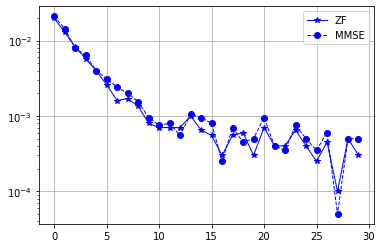

In [111]:
from matplotlib.markers import MarkerStyle


K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = int(1e4) # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 
sers = []
sers_mmse = []
for snr in range(SNR_max):
    # symbols for T timeslots
    x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
    x = np.take(constellation_points, x)

    # Channel 
    H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
    z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

    r = np.matmul(H, x) + (10**(-snr/20)) * z 

    # Complex to real representation 
    H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

    # 1-bit ADC 
    y = np.sign(r_re) 
    y = y[:, :N, :] + 1j*y[:, N:, :]

    # relaxed linear receiver 
    W_zf = np.linalg.pinv(H)
    W_mmse = np.matmul((H.conjugate()).transpose((0, 2, 1)), H) + ((np.eye(K)+1j*np.eye(K)) * np.ones((T, K, K)))
    W_mmse = np.linalg.inv(W_mmse)
    W_mmse = np.matmul(W_mmse, (H.conjugate()).transpose((0, 2, 1)))

    # Relaxed estimation of x  
    x_tilde = np.matmul(W_zf, y)
    x_tilde_mmse = np.matmul(W_mmse, y)
        

    # detection within each users (symbol-by-symbol)
    compare = np.abs(x_tilde - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1) 
    x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)

    compare = np.abs(x_tilde_mmse - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1)
    x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

    # Compare 
    ser = 1-np.sum(np.isclose(x, x_hat)) / (T * K)
    ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T*K)

    if snr % 5 == 0:
        print("snr: ", snr, "ser (zf): ", ser, "     |     ser(mmse): ", ser_mmse)
    sers.append(ser)
    sers_mmse.append(ser_mmse)



plt.figure()
plt.semilogy(sers, '-b*', linewidth=1, label='ZF') 
plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.grid() 
plt.legend()
plt.show()


## MIMO receiver with 1-bit-ADC (Linear Receiver) with N time transmission 
### monte-carlo simulation

____________________________________________________________________________________________________
trial :  0
snr:  -5 ser(zf):  0.11429999999999996    |   ser(mmse):  0.12004999999999999
snr:  0 ser(zf):  0.019299999999999984    |   ser(mmse):  0.021399999999999975
snr:  5 ser(zf):  0.0030000000000000027    |   ser(mmse):  0.003249999999999975
snr:  10 ser(zf):  0.0006500000000000394    |   ser(mmse):  0.0006000000000000449
snr:  15 ser(zf):  0.00044999999999995044    |   ser(mmse):  0.00029999999999996696
snr:  20 ser(zf):  0.00014999999999998348    |   ser(mmse):  0.00014999999999998348
snr:  25 ser(zf):  0.00029999999999996696    |   ser(mmse):  0.00029999999999996696
____________________________________________________________________________________________________
trial :  1
snr:  -5 ser(zf):  0.11434999999999995    |   ser(mmse):  0.12095
snr:  0 ser(zf):  0.019549999999999956    |   ser(mmse):  0.021199999999999997
snr:  5 ser(zf):  0.0028000000000000247    |   ser(mmse):  0

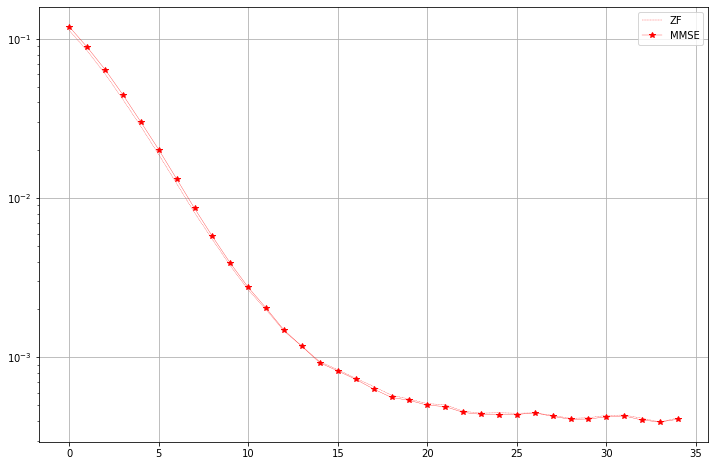

In [114]:
K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = int(1e4) # Total Transmission rounds 
SNR_max = 30


def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

sers_avg_zf = np.zeros((SNR_max+5))
sers_avg_mmse = np.zeros((SNR_max+5))
trials = 100
for t in range(trials):
    sers_zf = []
    sers_mmse = []
    print("_" * 100) 
    print("trial : ", t)
    for snr in range(-5, SNR_max):
        # symbols for T timeslots
        x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
        x = np.take(constellation_points, x)

        # Channel 
        H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
        z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

        r = np.matmul(H, x) + (10**(-snr/20)) * z 

        # Complex to real representation 
        H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

        # 1-bit ADC 
        y = np.sign(r_re)
        y = y[:, :N, :] + 1j * y[:, N:, :] 

        # relaxed linear receiver 
        W_zf = np.linalg.pinv(H)
        W_MMSE = np.matmul((H.conjugate()).transpose(0, 2, 1), H) + (10 ** (-snr/20)) * ((np.eye(K) + 1j * np.eye(K)) * np.ones(shape=(T, K, K)))
        W_MMSE = np.linalg.inv(W_MMSE) 
        W_MMSE = np.matmul(W_MMSE, (H.conjugate()).transpose(0, 2, 1))

        # Relaxed estimation of x  
        x_tilde_zf = np.matmul(W_zf, y)
        x_tilde_mmse = np.matmul(W_MMSE, y) 

        # detection within each users (symbol-by-symbol)
        compare = np.abs(x_tilde_zf - constellation_points)
        det_by_idx = np.argmin(compare, axis=-1) 
        x_hat_zf = np.take(constellation_points, det_by_idx).reshape(x_tilde_zf.shape)

        compare = np.abs(x_tilde_mmse - constellation_points)
        det_by_idx = np.argmin(compare, axis=-1) 
        x_hat_mmse = np.take(constellation_points, det_by_idx).reshape(x_tilde_mmse.shape) 

        # Compare 
        ser_zf = 1-np.sum(np.isclose(x, x_hat_zf)) / (T * K)
        ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T * K)

        if snr % 5 == 0:
            print(f"snr: ", snr, "ser(zf): ", ser_zf, "   |   ser(mmse): ", ser_mmse)
        sers_zf.append(ser_zf)
        sers_mmse.append(ser_mmse) 

    sers_avg_zf += np.array(sers_zf)
    sers_avg_mmse += np.array(sers_mmse)

sers_avg_zf /= trials
sers_avg_mmse /= trials

plt.figure(figsize=(12, 8))
plt.semilogy(sers_avg_zf, '--r', linewidth=0.3, label='ZF')
plt.semilogy(sers_avg_mmse, '-r*', linewidth=0.3, label='MMSE') 
plt.grid()
plt.legend()
plt.show()





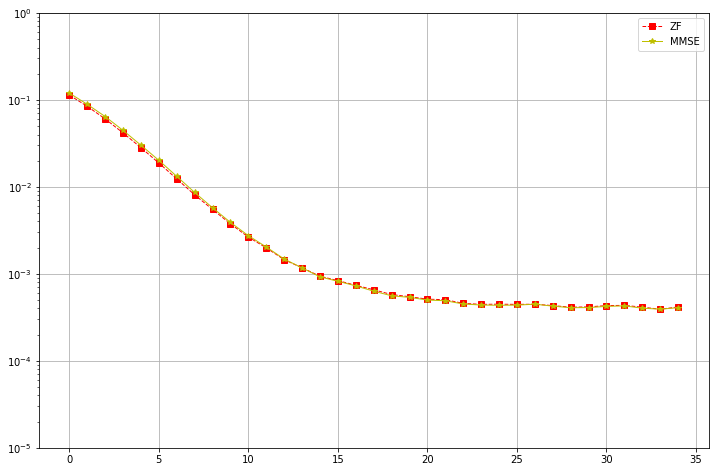

In [116]:

plt.figure(figsize=(12, 8))
plt.semilogy(sers_avg_zf, '--rs', linewidth=1, label='ZF')
plt.semilogy(sers_avg_mmse, '-y*', linewidth=1, label='MMSE') 
plt.yticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.grid()
plt.legend()
plt.show()

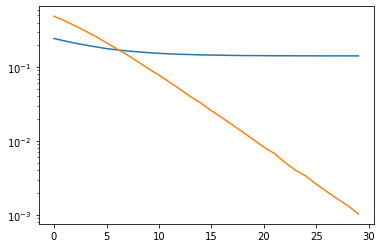

In [7]:
sers_avg_squeezed_loaded = np.load("./results/sers_avg_1_bit_zero_forcing.npy") 
sers_avg_real = np.load("./results/sers_avg_conventional_zero_forcing.npy")
plt.semilogy(sers_avg_squeezed_loaded / 100) 
plt.semilogy(sers_avg_real)
plt.show()

## Bussgang receiver

In [176]:
def make_symbol_space(K, M, cp):
    """
    Makes symbol space S = |M|^K 
    :params: 
    :   K (int) : number of users\n
    :   M (int) : level of modulation\n
    :returns:
    :   symbol_space (np.ndarray) : symbol space S=|M|^K
    """
    index_space = np.indices([M for _ in range(K)]).reshape(K, -1).T 
    symbol_space = np.take(cp, index_space)
    return symbol_space 

def comp2re(H, x, z, r):
    x_re = np.hstack((x.real, x.imag))
    z_re = np.hstack((z.real, x.imag))
    r_re = np.hstack((r.real, r.imag)) 
    H_re = np.block([
        [H.real, -H.imag],
        [H.imag, H.real]
    ])
    return H_re, x_re, z_re, r_re 

def symbol_by_symbol(x_tilde, constellation_points):
    compare = np.abs(x_tilde - constellation_points)
    det_by_idx = np.argmin(compare, axis=-1) 
    x_hat = np.take(constellation_points, det_by_idx).reshape(x_tilde.shape)
    return x_hat 

def covr(H):
    global N
    global T
    global snr  
    if T > 1:
        return np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N))
    else:
        return np.matmul(H, (H.conjugate()).T) + (10**(-snr/20))*(np.eye(N) + 1j * np.eye(N)) 

def bussgang(H, snr):
    global N 
    cov_r = covr(H)
    res = cov_r * ((np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N)))
    sqrt_diag_sigma = np.sqrt(np.linalg.inv(res))
    V = sqrt_diag_sigma * np.sqrt(2 / np.pi) 
    effective_channel = np.matmul(V, H) 

    ls = np.matmul(sqrt_diag_sigma, cov_r)
    rs1 = np.matmul(ls, sqrt_diag_sigma)
    ls = np.arcsin(rs1.real) + 1j * np.arcsin(rs1.imag)

    rs = rs1 - (10 ** (-snr / 20)) * np.matmul(sqrt_diag_sigma, sqrt_diag_sigma)
    effective_noise_covariance = ls - rs
    return effective_channel, effective_noise_covariance

snr:  -5 ser (zf):  0.11224999999999996   |  ser(mmse):  0.11465000000000003   |  ser(bzf): 0.35745000000000005
snr:  0 ser (zf):  0.018850000000000033   |  ser(mmse):  0.020000000000000018   |  ser(bzf): 0.23370000000000002
snr:  5 ser (zf):  0.0030000000000000027   |  ser(mmse):  0.003249999999999975   |  ser(bzf): 0.12429999999999997
snr:  10 ser (zf):  0.0009000000000000119   |  ser(mmse):  0.0008000000000000229   |  ser(bzf): 0.061350000000000016
snr:  15 ser (zf):  0.00019999999999997797   |  ser(mmse):  0.00019999999999997797   |  ser(bzf): 0.03749999999999998
snr:  20 ser (zf):  0.00034999999999996145   |  ser(mmse):  0.0005500000000000504   |  ser(bzf): 0.026150000000000007
snr:  25 ser (zf):  0.00034999999999996145   |  ser(mmse):  0.0006500000000000394   |  ser(bzf): 0.019499999999999962


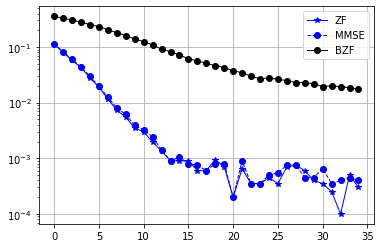

In [177]:
from matplotlib.markers import MarkerStyle


K = 2   # Number of users (transmitter antenna) 
N = 16   # Number of Receiver (Receive antenna)
M = 4   # level of modulation (4-QAM / QPSK)
T = 10000 # Total Transmission rounds 
SNR_max = 30 

# simple constellation points (normalized)
constellation_points = np.array([-1-1j, -1+1j, 1-1j, 1+1j])
constellation_points /= np.sqrt(2) 

# make symbol space = |M|^K  in case of using ML detection 
symbol_space = make_symbol_space(K, M, cp=constellation_points) 

sers = []
sers_mmse = []
sers_bzf = []

for snr in range(-5, SNR_max):
    x = np.random.randint(0, M, size=K * T).reshape(T, K, 1) 
    x = np.take(constellation_points, x)

    # Channel 
    H = (1 / np.sqrt(2)) * (np.random.randn(T, N, K) + 1j * np.random.randn(T, N, K))
    z = (1 / np.sqrt(2)) * (np.random.randn(T, N, 1) + 1j * np.random.randn(T, N, 1))

    r = np.matmul(H, x) + (10**(-snr/20)) * z 

    # Complex to real representation 
    H_re, x_re, z_re, r_re = comp2re(H, x, z, r) 

    # 1-bit ADC 
    y = np.sign(r_re) 
    y = y[:, :N, :] + 1j * y[:, N:, :]

    A, sigma_n = bussgang(H, snr)

    # relaxed linear receiver 
    W_zf = np.linalg.pinv(H)
    W_mmse = np.matmul((H.conjugate()).transpose((0, 2, 1)), H) + ((np.eye(K) + 1j * np.eye(K)) * np.ones((T, K, K)))
    W_mmse = np.linalg.inv(W_mmse)
    W_mmse = np.matmul(W_mmse, (H.conjugate()).transpose((0, 2, 1)))
    W_bzf = np.linalg.pinv(A)

    # Relaxed estimation of x  
    x_tilde_zf = np.matmul(W_zf, y)
    x_tilde_mmse = np.matmul(W_mmse, y)
    x_tilde_bzf = np.matmul(W_bzf, y)
        
    # detection within each users (symbol-by-symbol)
    x_hat_zf = symbol_by_symbol(x_tilde=x_tilde_zf, constellation_points=constellation_points)
    x_hat_mmse = symbol_by_symbol(x_tilde=x_tilde_mmse, constellation_points=constellation_points) 
    x_hat_bzf = symbol_by_symbol(x_tilde=x_tilde_bzf, constellation_points=constellation_points)

    # Compare 
    ser = 1-np.sum(np.isclose(x, x_hat_zf)) / (T * K)
    ser_mmse = 1-np.sum(np.isclose(x, x_hat_mmse)) / (T * K)
    ser_bzf = 1-np.sum(np.isclose(x, x_hat_bzf)) / (T * K)

    if snr % 5 == 0:
        print("snr: ", snr, "ser (zf): ", ser, "  |  ser(mmse): ", ser_mmse, "  |  ser(bzf):", ser_bzf)
    sers.append(ser)
    sers_mmse.append(ser_mmse)
    sers_bzf.append(ser_bzf)



plt.figure()
plt.semilogy(sers, '-b*', linewidth=1, label='ZF') 
plt.semilogy(sers_mmse, '--bo', linewidth=1, label='MMSE')
plt.semilogy(sers_bzf, '-r*', linewidth=1, label='BZF')
plt.grid() 
plt.legend()
plt.show()



In [169]:
cov_r = np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N))
def covr(H):
    global N
    global T
    global snr  
    if T > 1:
        return np.matmul(H, (H.conjugate()).transpose(0, 2, 1)) + (10 ** (-snr/20)) * (np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N))
    else:
        return np.matmul(H, (H.conjugate()).T) + (10**(-snr/20))*(np.eye(N) + 1j * np.eye(N)) 

def bussgang(H):
    global N 
    global snr
    cov_r = covr(H)
    res = cov_r * ((np.eye(N) + 1j * np.eye(N)) * np.ones(shape=(T, N, N)))
    sqrt_diag_sigma = np.sqrt(np.linalg.inv(res))
    V = sqrt_diag_sigma * np.sqrt(2 / np.pi) 
    effective_channel = np.matmul(V, H) 

    ls = np.matmul(sqrt_diag_sigma, cov_r)
    rs1 = np.matmul(ls, sqrt_diag_sigma)
    ls = np.arcsin(rs1.real) + 1j * np.arcsin(rs1.imag)

    rs = rs1 - (10 ** (-snr / 20)) * np.matmul(sqrt_diag_sigma, sqrt_diag_sigma)
    effective_noise_covariance = ls - rs
    return effective_channel, effective_noise_covariance

In [170]:
A, sigma_n = bussgang(H)

In [120]:

T = 1

# Effective Channel 
h_instance = H[0]
cov_r = covr(h_instance)
V = np.diag(np.sqrt(1/np.diag(cov_r))) * np.sqrt(2/np.pi)
A = np.matmul(V, h_instance) 
A
# Effective noise 

ls = np.matmul(np.diag(np.sqrt(1/np.diag(cov_r))), cov_r)
ls = np.matmul(ls, np.diag(np.sqrt(1/np.diag(cov_r))))
ls = np.arcsin(ls)

rs = np.matmul(np.diag(np.sqrt(1/np.diag(cov_r))), cov_r)
rs = np.matmul(rs, np.diag(np.sqrt(1/np.diag(cov_r)))) 
rs = rs - (10**(-snr/20)) * np.diag(1/np.diag(cov_r))

cov_n = (2/np.pi) * (ls - rs)
print(cov_n)
mean = np.zeros_like(z[0]).squeeze()
mean.shape

y_instance = y[0]
y_instance = y_instance[:N] + 1j * y_instance[N:]
x_hat = np.matmul(np.linalg.pinv(A), y_instance)
x_hat, x[0]

compare = np.abs(x_hat - constellation_points)
det_by_idx = np.argmin(compare, axis=-1)
x_hat = np.take(constellation_points, det_by_idx).reshape(x_hat.shape) 
x_hat, x[0]

(16, 16)
[[ 5.58111553e-01-6.65145450e-02j -8.93573381e-03+6.64233792e-04j
  -6.52130031e-04+4.31207827e-04j -5.57866736e-03+4.16410044e-03j
  -1.94770746e-02-1.00506398e-02j  8.58915613e-03-5.54532766e-03j
   1.96662936e-02-4.22900210e-03j -1.17736226e-02-2.98429514e-02j
   1.27926894e-03-7.20583900e-03j -6.59610058e-03-1.74030780e-02j
   5.32695354e-03-1.25494123e-02j -3.86680600e-06-1.36526054e-03j
   7.40983161e-03+1.33430711e-02j  2.15749457e-03-5.00076538e-03j
  -5.14345093e-04-5.89094652e-03j -2.12492588e-02+1.46296702e-02j]
 [ 8.92628499e-04+8.46173300e-03j  5.03203830e-01-3.23543979e-02j
   2.52369988e-02+2.67178336e-03j -2.37232537e-02-3.82516756e-02j
   1.92097542e-02-3.34689889e-03j -2.84587402e-02+8.00534594e-03j
  -4.86405248e-05+2.78969689e-05j  4.21346517e-02-1.21373199e-02j
   2.06982595e-03-1.90817593e-03j  4.56951522e-02+1.64148737e-02j
  -1.99720198e-03+1.96204391e-04j -1.49839721e-02+1.75153739e-03j
   1.15250469e-02-8.90321723e-03j -5.71652565e-05+2.74716414e-04j


ValueError: operands could not be broadcast together with shapes (16,1) (0,1) 

In [40]:
H[0].shape, x[0].shape, z[0].shape

((16, 2), (2, 1), (16, 1))